In [9]:
import sys,os
sys.path.append(r'C:\Users\MERFISH8\Scripts\CommonTools')
import MosaicToolsPy3 as mt
import numpy as np, matplotlib.pyplot as plt
import numpy
import pickle
import imp
imp.reload(mt)
#from PIL import Image
#pip install pillow=4.0.0
#pip install opencv-python
#conda activate py27
#python -m pip install Pillow

<module 'MosaicToolsPy3' from 'C:\\Users\\MERFISH8\\Scripts\\CommonTools\\MosaicToolsPy3.py'>

Started loading images
Finished loading images


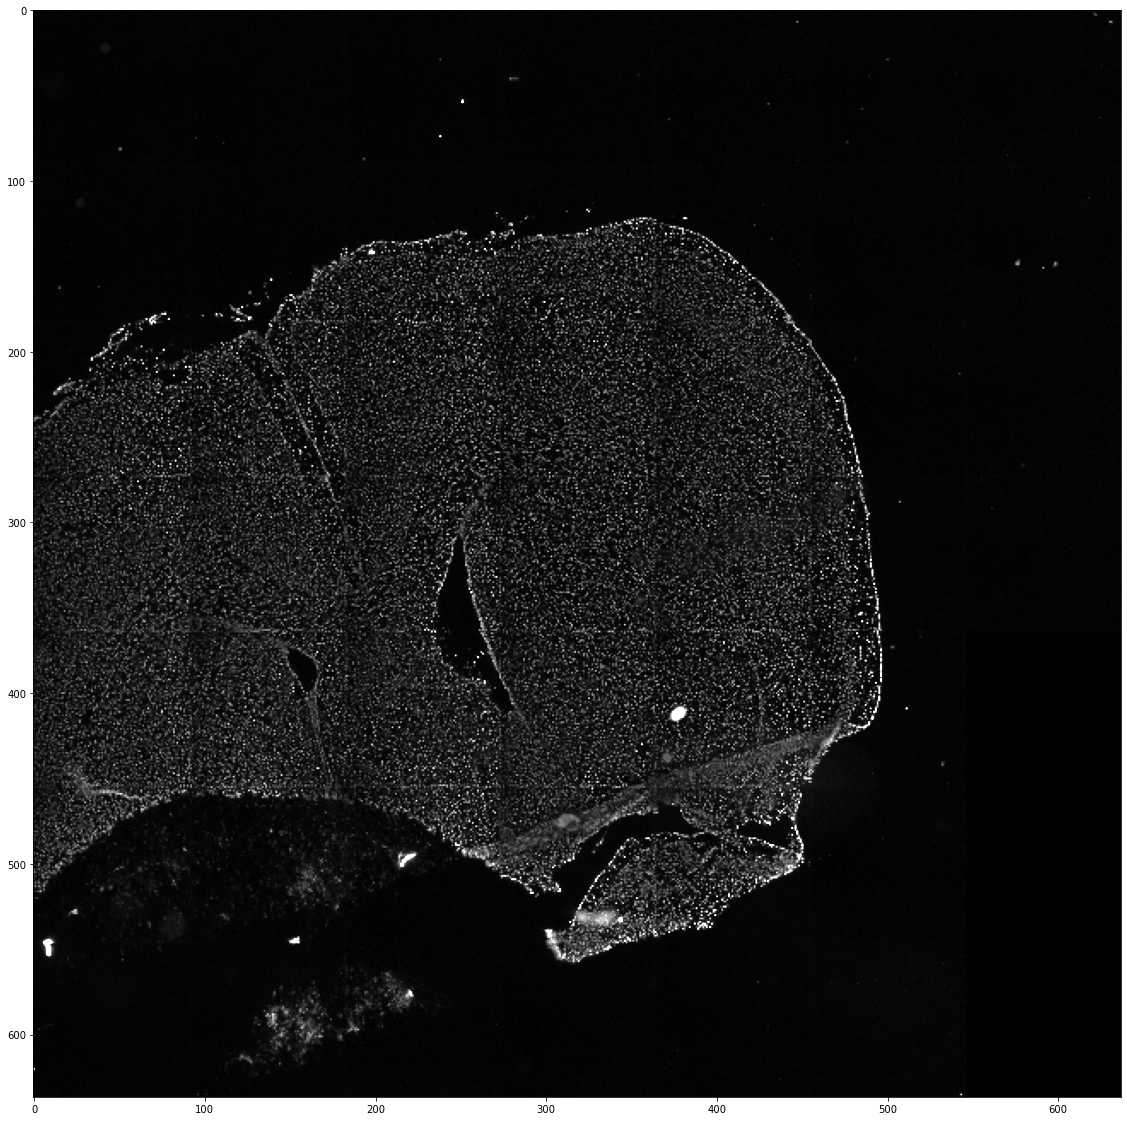

In [19]:
mosaic = mt.Mosaic()
folder = r'D:\Data\BB_WEA_Sind_12_11_2020\mosaic'
mosaic.load(folder,nmax=None)

#reload(mt)
mosaic.get_ims()
mosaic.get_mosaic(rot=0,um_per_pixel_dic={'10x':0.648,'60x':0.648,'100x':0.107,'20x':0.46},
                  invert_X=False,invert_Y=False,transpose=True)

plt.figure(figsize=(20,20))
plt.imshow(mosaic.im[::20,::20],vmax=12,vmin=0.75,cmap='gray')
plt.show()

In [20]:
mosaic.save(folder+'.png',im_min=0.75,im_max=12)

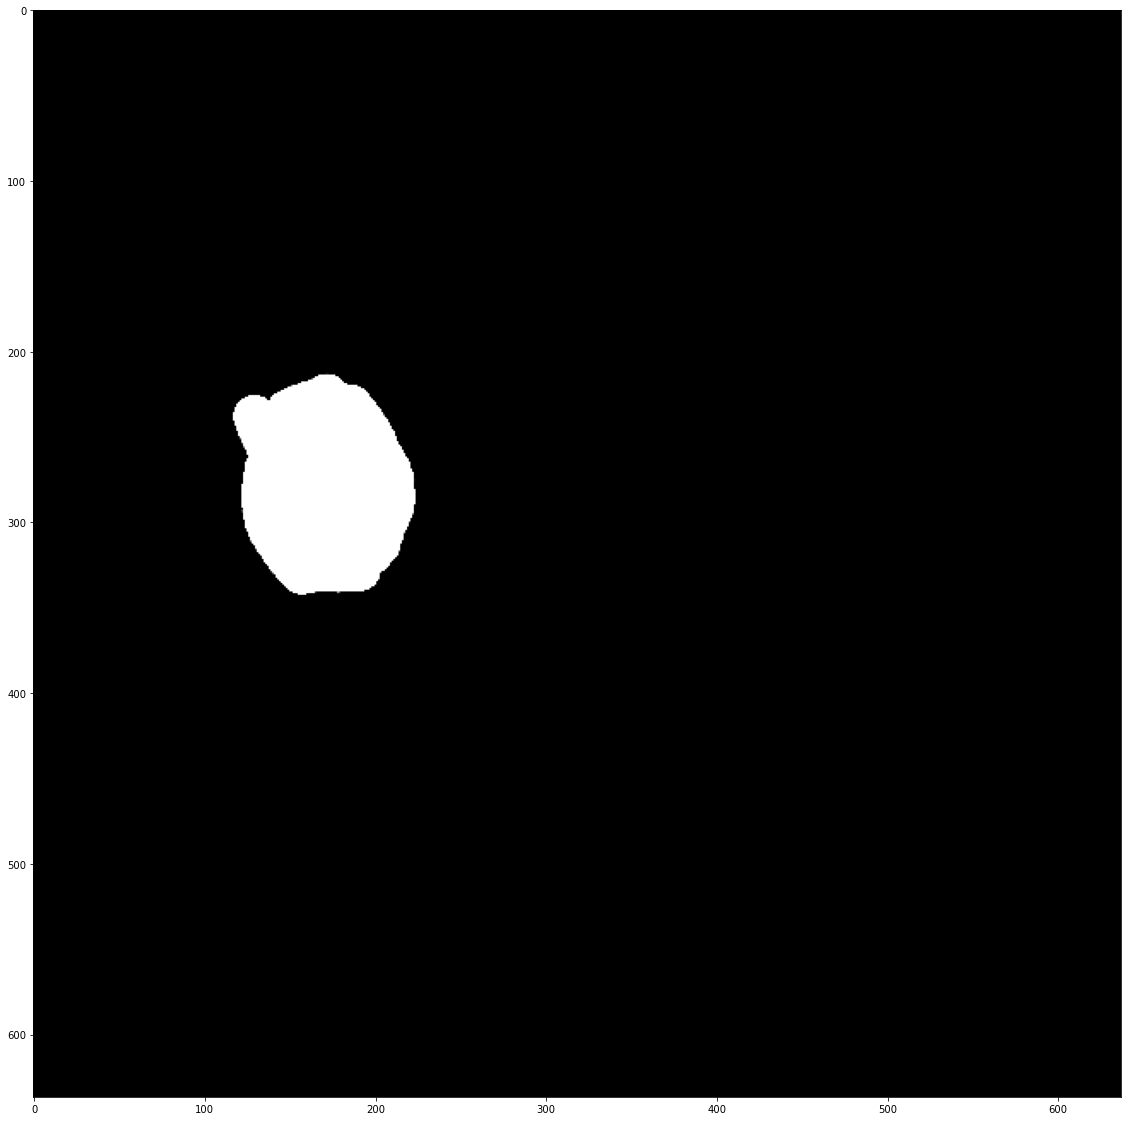

In [23]:
im = cv2.imread(folder+r"_mask.tif")

plt.figure(figsize=(20,20))
plt.imshow(im[::20,::20],cmap='gray')
plt.show()

C:\Users\MERFISH8\Scripts\CommonTools\MosaicToolsPy3.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return im[slices]


Number of snaps:57


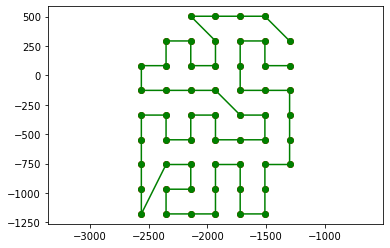

In [26]:
import matplotlib.pyplot as plt
import sys
import cv2
import numpy

low_mag_pixel_size = 0.65 #pixel size of lowmag
high_mag_pixel_size = 0.108
fov_sz = 2048.

xoffset,yoffset = 182.00,58.00 #offset between low mag and high mag objectives


x_start,y_start = 0,0 #starting positions




#image  = cv2.imread(os.path.dirname(folder)+os.sep+r"mosaic_mask.png")[:,:,0]
image = cv2.imread(folder+r"_mask.tif")[:,:,0]
xsz,ysz=image.shape

obj_ratio=low_mag_pixel_size/high_mag_pixel_size
sz=np.array([fov_sz/obj_ratio,fov_sz/obj_ratio])*0.95
sz_=[fov_sz/obj_ratio,fov_sz/obj_ratio]
im_=numpy.array(image)
xcand = np.arange(0,int(im_.shape[0]),int(sz[0]))+sz[0]/2
ycand = np.arange(0,int(im_.shape[1]),int(sz[1]))+sz[1]/2
x,y = zip(*mt.flatten([[(x__,y__) for x__ in xcand if np.sum(mt.grab_block(im_,[x__,y__],sz_))] for y__ in ycand]))
x,y= (numpy.array(x))/sz[0],(numpy.array(y))/sz[1]


Point = complex
cities = frozenset(Point(x[i],y[i]) for i in range(len(x)))
cities_sort=mt.alter_tour(mt.greedy_tsp(cities))
x2=[val.real for val in cities_sort]
y2=[val.imag for val in cities_sort]
#plt.figure(figsize=(20,20))
#plt.imshow(numpy.array(im_small)>0)
x_ = (numpy.array(x2))*sz[0]
y_ = (numpy.array(y2))*sz[1]

filename=os.path.dirname(folder)+os.sep+r'pos.txt'
pix_sz=high_mag_pixel_size*obj_ratio
dics=mosaic.dics
pos_x = numpy.array([dic['x_um'] for dic in dics],dtype=int)
pos_y = numpy.array([dic['y_um'] for dic in dics],dtype=int)
starts=min(pos_x),min(pos_y)
offset = fov_sz/2*low_mag_pixel_size

x = starts[0]+(numpy.array(x2))*sz[0]*pix_sz+xoffset-offset#This is -X offset
y = starts[1]+(numpy.array(y2))*sz[1]*pix_sz+yoffset-offset#This is -Y offset

#####################################################################           XMIN             #########################



#x_min,x_max=-np.inf,np.inf
def select_points(x,y,delta_x_keep):
    x_min = np.mean(x)-delta_x_keep/2.
    x_max = np.mean(x)+delta_x_keep/2.
    x_keep,y_keep = [],[]
    for x_t,y_t in zip(x,y):
        if x_t>x_min and x_t<x_max:
            x_keep.append(x_t)
            y_keep.append(y_t)
    x_keep = np.array(x_keep)
    y_keep = np.array(y_keep)
    return x_keep,y_keep
x_keep,y_keep = select_points(x,y,np.inf)
plt.plot(y_keep,x_keep,'ro')
#x_keep,y_keep = select_points(x,y,11000.)





ind0 = np.argmin((x_keep-x_start)**2+(y_keep-y_start)**2)

x_keep = np.roll(x_keep,-ind0)
y_keep = np.roll(y_keep,-ind0)
fid=open(filename,'w')
for x_t,y_t in zip(x_keep,y_keep):
    fid.write(str(x_t)+','+str(y_t)+'\n')
fid.close()
print("Number of snaps:" + str(len(x_keep)))

#plt.imshow(im_)
plt.plot(y_keep,x_keep,'g-o')

plt.axis('equal')
plt.show()

In [53]:
import sys,os,glob
sys.path.append(r'C:\Users\MERFISH8\Scripts\CommonTools')
import numpy as np, matplotlib.pyplot as plt
import pickle
import imp
import MaxViewer_py3 as mv
import tifffile
from tqdm import tqdm_notebook as tqdm
import AlignmentTools_py3 as at

In [54]:
#Useful functions
import cv2
def quick_norm(im,s=50):
    return np.array([im_/cv2.blur(im_,(s,s))for im_ in im.astype(np.float32)])
from sklearn.cluster import DBSCAN
def get_local_max(im_dif,th_fit,delta=2,delta_fit=3,dbscan=True):
    """Given a 3D image <im_dif> as numpy array, get the local maxima in cube -<delta>_to_<delta> in 3D.
    Optional a dbscan can be used to couple connected pixels with the same local maximum. 
    This is important if saturating the camera values.
    
    Returns: Xh - a list of z,x,y and brightness of the local maxima
    """
    z,x,y = np.nonzero(im_dif>th_fit)
    zmax,xmax,ymax = im_dif.shape
    in_im = im_dif[z,x,y]
    keep = np.ones(len(x))>0
    for d1 in range(-delta,delta+1):
        for d2 in range(-delta,delta+1):
            for d3 in range(-delta,delta+1):
                keep &= (in_im>=im_dif[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])
    z,x,y = z[keep],x[keep],y[keep]
    h = in_im[keep]
    Xh = np.array([z,x,y,h]).T
    if dbscan:
        from sklearn.cluster import DBSCAN
        db = DBSCAN(eps=1, min_samples=1, metric='euclidean')
        X = np.array([z,x,y]).T
        db.fit(X)
        l = db.labels_
        Xh = []
        for l_ in np.unique(l):
            keep = l==l_
            imax = np.argmax(h[keep])
            Xh.append([z[keep][imax],x[keep][imax],y[keep][imax],h[keep][imax]])
        Xh = np.array(Xh)
    
    if delta_fit!=0:
        z,x,y,h = Xh.T
        z,x,y = z.astype(int),x.astype(int),y.astype(int)
        im_centers = [[],[],[],[]]
        for d1 in range(-delta_fit,delta_fit+1):
            for d2 in range(-delta_fit,delta_fit+1):
                for d3 in range(-delta_fit,delta_fit+1):
                    if (d1*d1+d2*d2+d3*d3)<=(delta_fit*delta_fit):
                        im_centers[0].append((z+d1))
                        im_centers[1].append((x+d2))
                        im_centers[2].append((y+d3))
                        im_centers[3].append(im[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])

        im_centers_ = np.array(im_centers)
        im_centers_[-1] -= np.min(im_centers_[-1],axis=0)
        zc = np.sum(im_centers_[0]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        xc = np.sum(im_centers_[1]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        yc = np.sum(im_centers_[2]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        Xh = np.array([zc,xc,yc,h]).T
    return Xh
import AlignmentTools_py3 as at
def series_align(im1,im2,s = 256,gb=30):
    """
    Given 2 3D images <im1> and <im2> this performs a fft based registration. 
    Robustness measures:
    1) Uses local gaussian correction (dividing the images by gaussian blur) with a kernel size <gb> of 30 piexels. 
    (This is to avoid the fft getting confused by global illumination and focusing on the feature at scale <gb>)
    
    2) Will tile the images <im1> and <im2> in s x s little images and compare each one. Will then use the consensus registration
    
    Returns:
    tzxy - the delta z,x and y between the images
    vecs - a list of tzxy for each subimage comparison (see point 2 above) to troubleshoot
    """
    
    sz,sx,sy = im1.shape
    vecs = []
    for ix in range(0,sx-1,s):
        for iy in range(0,sy-1,s):
            vecs.append(at.fft3d_from2d(im1[:,ix:ix+s,iy:iy+s],im2[:,ix:ix+s,iy:iy+s],gb=gb))
    tzxy = np.median(vecs,axis=0)
    #consistency = np.mean(np.abs(vecs-tzxy),axis=0)
    return tzxy,vecs


In [49]:
H_folders = glob.glob('D:\Data\BB_WEA_Sind_12_11_2020\H*')
fovs = glob.glob(H_folders[0]+os.sep+'*.tif')
fovs = [os.path.basename(fv)for fv in np.sort(fovs)]


fov = fovs[2]
ims = []
ims_nms = []
cols = ['750','647','561','405']
ncols = len(cols)
for fld in tqdm(H_folders):
    im = tifffile.imread(fld+os.sep+fov)
    for icol,col in enumerate(cols):
        ims.append(im[icol::ncols])
        ims_nms.append(os.path.basename(fld)+'_'+col)

<ipython-input-49-a3d1b82686f9>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(H_folders):


In [ ]:
im1 = np.percentile(im1)

10.14979273706825


<IPython.core.display.Javascript object>


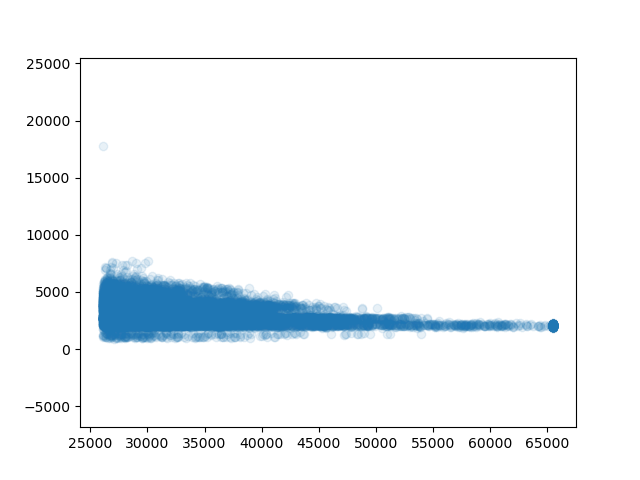

(24100.95, 67508.05, 83.59999999999991, 18594.4)

In [113]:
im1,im2 = ims[ncols+2],ims[ncols+1]
th = np.percentile(im1,99.99)
z,x,y = np.where(im1>th)
h1,h2 = im1[z,x,y],im2t[z,x,y]
keep = h1/h2
#keep = (keep>1/3.)&(keep<3.)&(h1>10000)&(h2>10000)
#h1,h2 = h1[keep],h2[keep]
print(np.median(h1/h2))
plt.figure()
plt.plot(h1,h2,'o',alpha=0.1)
plt.axis('equal')

In [ ]:
im1,im2 = ims[ncols+2],ims[ncols+1]


<IPython.core.display.Javascript object>


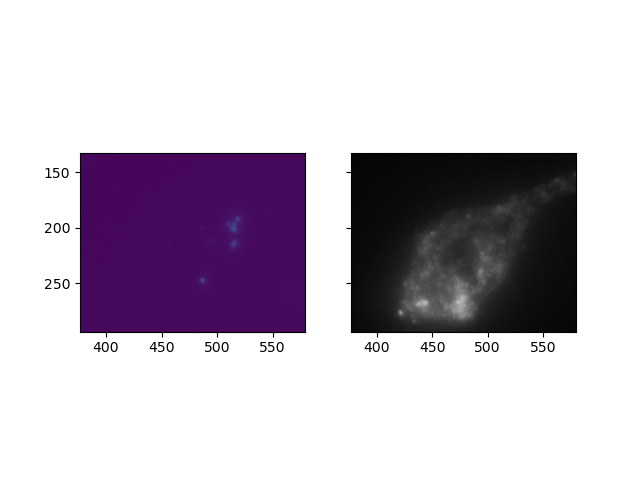

In [117]:
i=1
im1,im2 = ims[i],ims[i+ncols]
im2t = at.translate(im2,txyz)
f,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True)
ax1.imshow(np.max(im1,0))
ax2.imshow(np.max(im2t/im1,0),vmax=50,vmin=1,cmap='gray')


In [65]:
im2t = at.translate(im2,txyz)

<IPython.core.display.Javascript object>


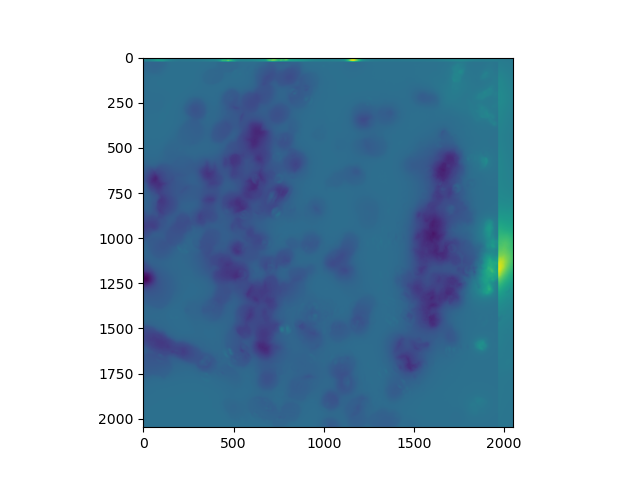

<IPython.core.display.Javascript object>


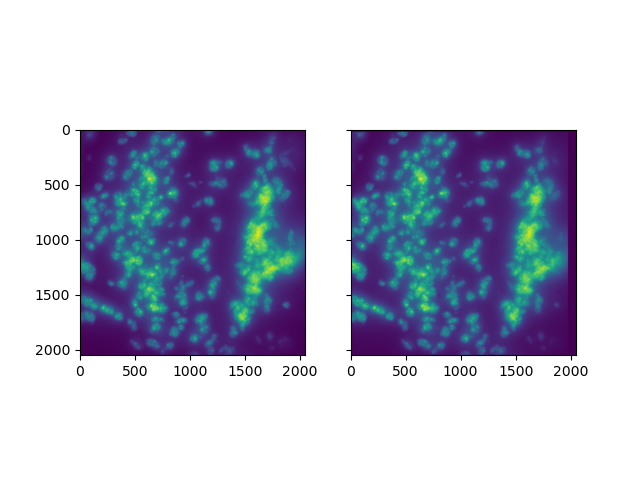

In [61]:
?at.translate

In [60]:
im1,im2 = ims[3+4*0],ims[3+4]
txyz,vecs = series_align(im1,im2,s = 256,gb=30)

In [40]:
%matplotlib notebook

<IPython.core.display.Javascript object>


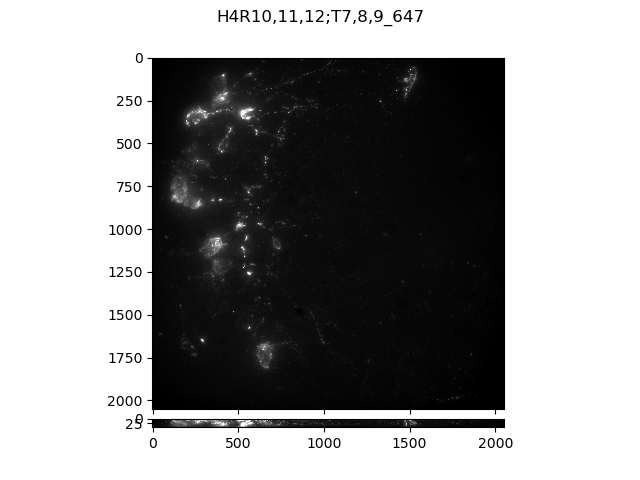

In [50]:
obj = mv.imshow_mark_3d(ims,image_names=ims_nms)

In [44]:
obj.dic_min_max

{0: [467, 4407],
 1: [865, 32993],
 2: [852, 65535],
 4: [680, 5351],
 5: [2184, 10343],
 9: [1487, 4835]}

In [51]:
obj.index_im

21